# Natural Earth 10 m land polygon

<https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-land/>

In [1]:
# import libraries
import os
from datetime import datetime, timezone
from zipfile import BadZipFile, ZipFile
import geopandas as gpd
import matplotlib.pyplot as plt
import pooch
from matplotlib import ticker
import climag.plot_configs as cplt

In [2]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-03-10 12:35:36.117585+00:00


In [3]:
# base data download directory
SUB_DIR = os.path.join("data", "boundaries", "NaturalEarth")
os.makedirs(SUB_DIR, exist_ok=True)

URL = (
    "https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip"
)
KNOWN_HASH = None
FILE_NAME = "ne_10m_land.zip"

# file name for the GeoPackage where the boundary vector layers will be saved
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries.gpkg")

DATA_DIR_TEMP = os.path.join(SUB_DIR, "temp")

os.makedirs(DATA_DIR_TEMP, exist_ok=True)

In [4]:
# download data if necessary
if not os.path.isfile(os.path.join(SUB_DIR, FILE_NAME)):
    pooch.retrieve(
        url=URL,
        known_hash=KNOWN_HASH,
        fname=FILE_NAME,
        path=SUB_DIR
    )

    with open(
        os.path.join(SUB_DIR, f"{FILE_NAME[:-4]}.txt"), "w", encoding="utf-8"
    ) as outfile:
        outfile.write(
            f"Data downloaded on: {datetime.now(tz=timezone.utc)}\n"
            f"Download URL: {URL}"
        )

In [5]:
DATA_FILE = os.path.join(SUB_DIR, FILE_NAME)

In [6]:
ZipFile(DATA_FILE).namelist()

['ne_10m_land.README.html',
 'ne_10m_land.VERSION.txt',
 'ne_10m_land.cpg',
 'ne_10m_land.dbf',
 'ne_10m_land.prj',
 'ne_10m_land.shp',
 'ne_10m_land.shx']

In [7]:
data = gpd.read_file(f"zip://{DATA_FILE}!ne_10m_land.shp")

In [8]:
data.head()

,featurecla,scalerank,min_zoom,geometry
0,Land,0.0,0.0,"MULTIPOLYGON (((-0.00029 -71.49903, 0.01555 -7..."
1,Land,6.0,5.0,"MULTIPOLYGON (((166.13697 -50.86435, 166.20525..."
2,Land,5.0,3.0,"MULTIPOLYGON (((-78.78897 -33.60906, -78.78038..."
3,Land,6.0,6.0,"MULTIPOLYGON (((163.98512 -20.04762, 163.98609..."
4,Land,5.0,4.0,"MULTIPOLYGON (((134.70737 -6.58904, 134.72006 ..."


In [9]:
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

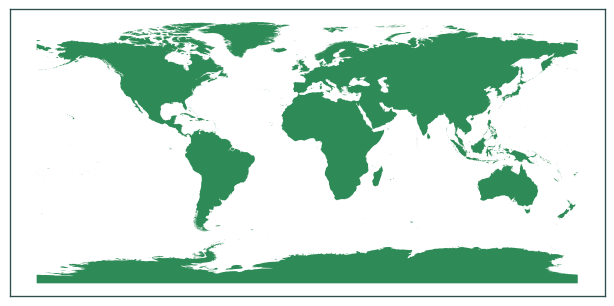

In [10]:
data.plot(figsize=(8, 8), color="seagreen")
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

In [11]:
# crop Ireland's boundary
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")

In [12]:
data_cropped = data.clip(ie.buffer(12500).to_crs(4326))

In [13]:
data_cropped

,featurecla,scalerank,min_zoom,geometry
7,None,NaN,NaN,"MULTIPOLYGON (((-9.47671 51.44811, -9.47643 51..."
0,Land,0.0,0.0,"POLYGON ((-6.11278 53.48672, -6.12442 53.46857..."
2,Land,5.0,3.0,"POLYGON ((-9.95181 53.95783, -9.94054 53.95995..."
3,Land,6.0,6.0,"MULTIPOLYGON (((-9.63834 53.25104, -9.65831 53..."


In [14]:
# dissolve features
data_cropped["name"] = "Ireland"

In [15]:
data_cropped = data_cropped.dissolve(by="name", as_index=False)

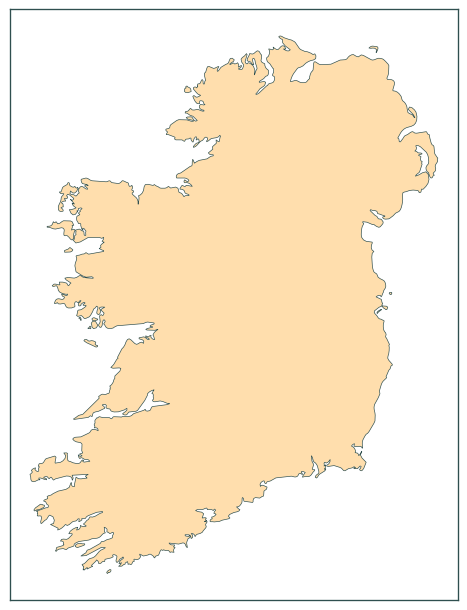

In [16]:
data_cropped.plot(
    figsize=(8, 8), color="navajowhite", edgecolor="darkslategrey",
    linewidth=.5
)
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

In [17]:
data_cropped.to_file(GPKG_BOUNDARY, layer="ne_10m_land_4326_IE")

In [18]:
# Irish Transverse Mercator
data_cropped.to_crs(2157, inplace=True)

In [19]:
data_cropped

,name,geometry,featurecla,scalerank,min_zoom
0,Ireland,"MULTIPOLYGON (((474445.798 543242.050, 468956....",Land,0.0,0.0


In [20]:
data_cropped.to_file(GPKG_BOUNDARY, layer="ne_10m_land_2157_IE")

In [21]:
# bounding box
ie_bound = gpd.GeoDataFrame(geometry=data_cropped.envelope.buffer(100000))

In [22]:
ie_bound

,geometry
0,"POLYGON ((330424.324 519708.048, 330424.324 96..."


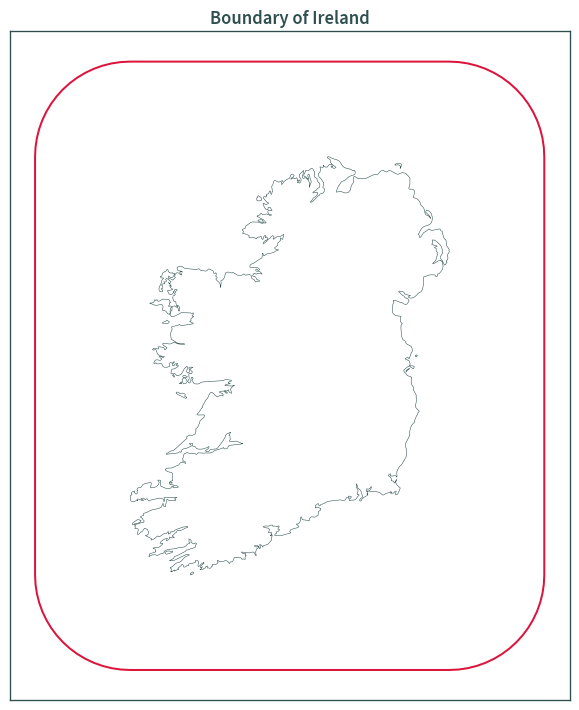

In [23]:
base = ie_bound.boundary.plot(color="crimson", figsize=(7.5, 7.5))
data_cropped.boundary.plot(ax=base, color="darkslategrey", linewidth=.4)

plt.tick_params(labelbottom=False, labelleft=False)

plt.title("Boundary of Ireland")
plt.tight_layout()
plt.show()

In [24]:
ie_bound.to_file(GPKG_BOUNDARY, layer="ne_10m_land_2157_IE_BBOX")

In [25]:
# difference between bbox and land polygon
ie_bound = ie_bound.overlay(data_cropped, how="difference")

In [26]:
ie_bound

,geometry
0,"POLYGON ((330424.324 960113.588, 330905.852 96..."


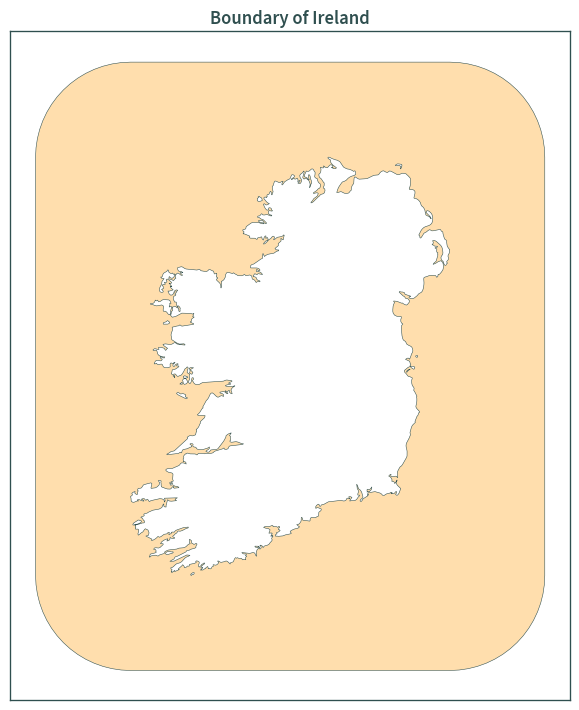

In [27]:
base = ie_bound.plot(
    color="navajowhite", figsize=(7.5, 7.5), edgecolor="darkslategrey",
    linewidth=.4
)

plt.tick_params(labelbottom=False, labelleft=False)

plt.title("Boundary of Ireland")
plt.tight_layout()
plt.show()

In [28]:
ie_bound.to_file(GPKG_BOUNDARY, layer="ne_10m_land_2157_IE_BBOX_DIFF")